In [1]:
#Import modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')
import math

In [2]:
data_train = pd.read_csv("KS_train_data.csv", delimiter=",")
data_train.set_index('project_id', inplace=True)
data_test = pd.read_csv("KS_test_data.csv", delimiter=",")
data_test.set_index('project_id', inplace=True)
list(data_train.head(0))
#https://data.world/rdowns26/kickstarter-campaigns

['backers_count',
 'blurb',
 'category',
 'converted_pledged_amount',
 'country',
 'created_at',
 'currency',
 'deadline',
 'fx_rate',
 'goal',
 'launched_at',
 'name',
 'pledged',
 'staff_pick',
 'usd_pledged',
 'location',
 'funded',
 'subcategory',
 'project_url',
 'reward_url']

    backers_count: numbers of persons who have contributed monetary to the project
    blurb: short description of the project underneath the project title
    category: each project is classified in a primary category - art, comics, crafts, dance, design, fashion,        film & video, food, games, journalism, music, photography, publishing, technology, theater
    converted_pledged_amount: amount monetary that was donated in total to the project
    country: 2 letter identifier e.g. UK of the country dated in location - restricts search to the country and                                 then cities are displayed as recommendations
    created_at: UNIX date 
    currency: monetary currency which the project accepts for payments and provides information about                        e.g. rewards brackets 
    deadline: UNIX standard time convertor - last day date of the funding period https://www.epochconverter.com/
    fx_rate: rate of conversion from one currency to USD
    goal: monetary value needed to be donated for the kickstarter project to be be a success
    launched_at: UNIX day date of the first day in the funding period - after project approval
    name: project name - product name or short description of goal
    pledged: total money value raised
    staff_pick: boolean value if staff selected a project -  get prime placement on the website, be promoted to     Kickstarter's 2 million followers on Facebook and Twitter, or appear in Kickstarter's "Projects We Love"                     email, which reaches more than 4 million inboxes every week.  
    usd_pledged: pledged value converted into USD dollars
    location: city, country/state for US - explore category shows projects which are in a specific geolocational part of the world. Posibillity of searching for a project in any city of the world as a filter.
    funded: boolean value whether the project goal has been met through funding 
    subcategory: can be categorised as the category or be in a specific subfield of the primary category
    project_url: website url of the project page 
    reward_url: website url of rewards page - there exist tiers that backers which donate a specific amount         of money will receive

In [3]:
list(data_test.head(0))

['blurb',
 'category',
 'country',
 'created_at',
 'currency',
 'deadline',
 'fx_rate',
 'goal',
 'launched_at',
 'name',
 'staff_pick',
 'location',
 'subcategory',
 'project_url',
 'reward_url']

In [22]:
count_pick = count_fund = 0
data_n = data_train[['staff_pick', 'funded']]
for i in range(len(data_n)):
    staff_pick, fund = data_n.iloc[i]
    if staff_pick == True:
        count_pick = count_pick + 1
        if fund == True:
            count_fund = count_fund + 1
count_pick, count_fund #13950 12483      -- 89.48%

(13950, 12483)

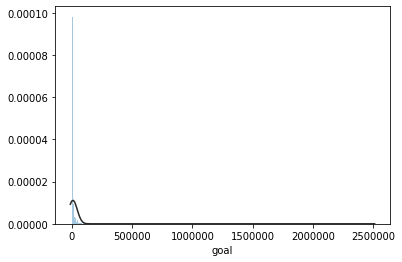

In [8]:
#distribution of goals funded, distributions of goals not founded
data_dgf = data_train[['goal', 'funded']]
data_dgft = data_dgf[data_dgf['funded']  == True]
data_dgfn = data_dgf[data_dgf['funded']  == False]
sns.distplot(data_dgft['goal'], fit=norm, kde=False, bins = 350)

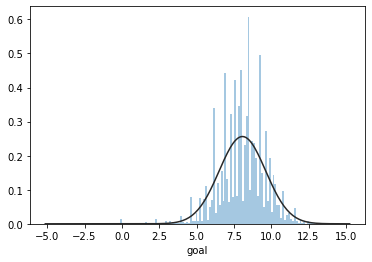

In [11]:
sns.distplot(np.log(data_dgft['goal']), fit=norm, kde=False, bins = 150)

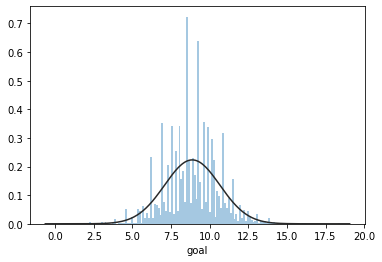

In [10]:
sns.distplot(np.log(data_dgfn['goal']), fit=norm, kde=False, bins = 150)

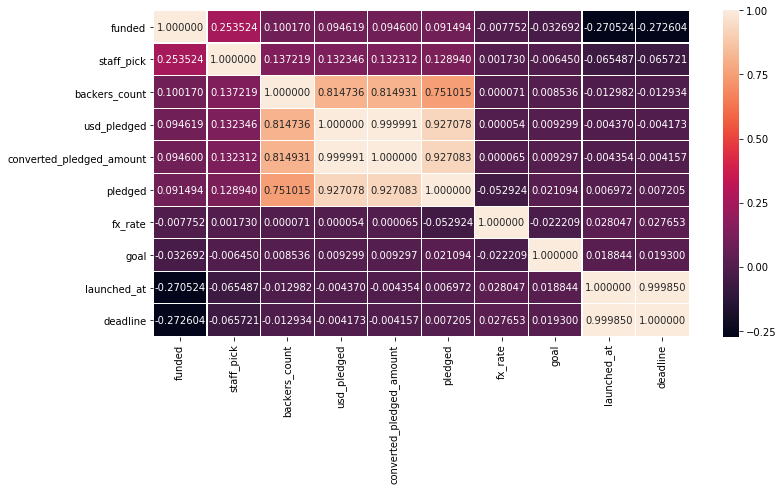

In [34]:
#measure length of blurb
corr = data_train.corr()
cols = corr.nlargest(10, 'funded').index
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(corr.loc[cols,cols], annot = True, fmt = "f", linewidths = .1, ax=ax)

In [3]:
#data_train['blurb_length']= len(data_train['blurb'])
#data_train['blurb_length'] = data_train.notnull().apply(lambda row: len(row['blurb']), axis = 1)
#https://stackoverflow.com/questions/51652640/getting-error-typeerror-object-of-type-float-has-no-len-in-pandas
data_train['blurb'].astype(str)
blurb_length = []
for i in range(len(data_train)):
    if data_train.iloc[i].blurb != data_train.iloc[i].blurb:
        blurb_length.append(0)
    else:
        blurb_length.append(len(data_train.iloc[i].blurb))   
#data_train.loc['KS_005423']

In [4]:
data_train['blurb_length'] = blurb_length
data_train['blurb_length']
data_train['funded'].corr(data_train['blurb_length']) #0.032002518832337956

0.032002518832337956

In [5]:
from datetime import date, datetime
#datetime.utcfromtimestamp(data_train.loc['KS_005423'].launched_at).strftime('%Y-%m-%d')
#created_at, deadline, launched_at
launched_at = []
created_at = []
deadline = []
for i in range(len(data_train)):
    launched_at.append(datetime.utcfromtimestamp(data_train.iloc[i].launched_at).strftime('%Y-%m-%d'))
    created_at.append(datetime.utcfromtimestamp(data_train.iloc[i].created_at).strftime('%Y-%m-%d'))
    deadline.append(datetime.utcfromtimestamp(data_train.iloc[i].deadline).strftime('%Y-%m-%d'))

In [6]:
#(date(launched_at[0]) - date(created_at[0])).days
date_format = "%Y-%m-%d"
#a = launched_at[1]
#b = created_at[1]
#a = datetime.strptime(a, date_format)
#b = datetime.strptime(b, date_format)
#delta = a - b
#delta.days
period_lc = []
period_dl = []
money_pday = []
for i in range(len(data_train)):
    l = launched_at[i]
    l = datetime.strptime(l, date_format)
    c = created_at[i]
    c = datetime.strptime(c, date_format)
    d = deadline[i]
    d = datetime.strptime(d, date_format)
    lc = l - c
    period_lc.append(lc.days)
    dl = d - l
    period_dl.append(dl.days)
    money_pday.append(math.ceil(data_train.iloc[i].goal / dl.days)) 

In [7]:
data_train['period_lc'] = period_lc
data_train['period_dl'] = period_dl
data_train['money_pday'] = money_pday
data_train['funded'].corr(data_train['period_lc']) #0.014442376611904716
#(0.1099845023270497, 0.0)
data_train['funded'].corr(data_train['period_dl']) #-0.0682284871783299
#(-0.04618922174000769, 1.7812979689710794e-62)
data_train['funded'].corr(data_train['money_pday']) #-0.021079961415708823
#tau, p_value (-0.1772279975606545, 0.0)s
tau, p_value = stats.kendalltau(data_train['funded'], data_train['period_lc'])
tau, p_value

(0.1099845023270497, 0.0)

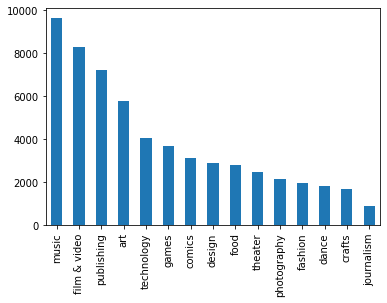

In [19]:
data_train[data_train['funded']  == True]['category'].value_counts().plot.bar()
#cat = ["music", "film & video", "publishing", "art", "technology", "games", "comics", "design", "food", "theater", "photography", "fashion", "dance", "crafts", "journalism"]

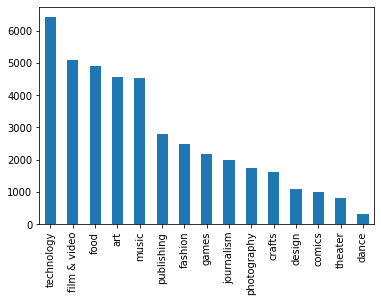

In [20]:
data_train[data_train['funded']  == False]['category'].value_counts().plot.bar()

In [22]:
data_train[data_train['funded']  == True]['country'].value_counts()

US    46704
GB     4339
CA     1707
AU      727
?       575
DE      397
FR      391
SE      244
MX      225
NL      218
IT      210
ES      209
NZ      170
DK      168
JP      159
CN      131
IE      113
HK       94
CH       80
NO       74
SG       69
IN       62
BE       58
AT       54
IL       48
KR       40
BR       39
CZ       38
ZA       38
TH       38
      ...  
GL        2
GU        2
BY        2
CY        2
AE        2
KP        2
FM        2
MT        1
VU        1
KZ        1
NE        1
TL        1
KW        1
GP        1
TJ        1
SK        1
IR        1
LA        1
ZW        1
CI        1
AG        1
GQ        1
MD        1
XK        1
GM        1
AX        1
LC        1
DM        1
FJ        1
QA        1
Name: country, Length: 151, dtype: int64

In [24]:
data_train[data_train['funded']  == False]['country'].value_counts()

US    30012
GB     3676
CA     1804
AU     1066
DE      572
IT      472
NL      468
FR      379
ES      327
MX      256
SE      221
NZ      209
DK      153
?       153
IE      125
NO      107
BE      106
CH      105
JP       77
AT       76
HK       71
IN       61
SG       52
PR       49
CN       47
PL       34
KR       33
CO       32
UA       30
RU       30
      ...  
BF        1
ML        1
PY        1
SY        1
GE        1
ME        1
MW        1
CG        1
FO        1
LY        1
BD        1
KZ        1
SS        1
SJ        1
TT        1
KP        1
FJ        1
BJ        1
CK        1
GL        1
LC        1
GY        1
SO        1
UY        1
CW        1
DJ        1
TN        1
MT        1
KW        1
AG        1
Name: country, Length: 158, dtype: int64

In [8]:
data_train['name_length'] = data_train['name']
name_length = []
for i in range(len(data_train)):
    if data_train.iloc[i].name_length != data_train.iloc[i].name_length:
        name_length.append(0)
    else:
        name_length.append(len(data_train.iloc[i].name_length))   

In [9]:
data_train['name_length'] = name_length
data_train['funded'].corr(data_train['name_length']) #0.12593483192454363

0.12593483192454363

In [10]:
#numerical vector for neural network
#features selected: 'goal', 'staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length'
#output: two nodes - founded, not founded
data_nn = data_train[['goal', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length']]
#data_nn['goal'].min() #100000000.0 #0.01
#data_nn['blurb_length'].min() #150 #0
#data_nn['period_lc'].min() #2220   #0
#data_nn['period_dl'].min() #92      #1
#data_nn['money_pday'].min() #13750000 #1
#standardize: staff_pick
boolean_v = []
for i in range(len(data_train)):
    boolean = data_train.iloc[i].staff_pick
    if boolean == True:
        boolean_v.append(1)
    elif boolean == False:
        boolean_v.append(0)
data_nn['staff_pick'] = boolean_v
#money_pday
data_nn['money_pday'] = (np.log(data_nn['money_pday'])-np.log(data_nn['money_pday']).mean())/np.log(data_nn['money_pday']).std()
#period_dl
data_nn['period_dl'] = (data_nn['period_dl']-data_nn['period_dl'].mean())/data_nn['period_dl'].std()
#period_lc
data_nn['period_lc'] = (data_nn['period_lc']-data_nn['period_lc'].mean())/data_nn['period_lc'].std()
#blurb_length
data_nn['blurb_length'] = (data_nn['blurb_length']-data_nn['blurb_length'].mean())/data_nn['blurb_length'].std()
#goal
data_nn['goal'] = (data_nn['goal']-data_nn['goal'].mean())/data_nn['goal'].std()
#name_length
data_nn['name_length'] = (data_nn['name_length']-data_nn['name_length'].mean())/data_nn['name_length'].std()

In [11]:
boolean_v = []
for i in range(len(data_train)):
    boolean = data_train.iloc[i].funded
    if boolean == True:
        boolean_v.append(1)
    elif boolean == False:
        boolean_v.append(0)
data_nn['funded'] = boolean_v
train, test = train_test_split(data_nn, test_size = 0.3)
data_inputs = train[['goal', 'staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length']]
targets = data_inputs.to_dict('index')

In [12]:
data = data_nn[['goal', 'staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length', 'funded']]
dataset = data.values
#split our dataset into input features (X) and the feature we wish to predict (Y)
X = dataset[:,0:7]
Y = dataset[:,7]
scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler.fit(scaler, X)
X_scale = scaler.transform(X)
X_scale
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)


In [13]:
#https://machinelearningmastery.com/keras-functional-api-deep-learning/
#https://www.freecodecamp.org/news/how-to-build-your-first-neural-network-to-predict-house-prices-with-keras-f8db83049159/
#Multilayer Perceptron
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

input_l = Input(shape=(7,))
hidden1 = Dense(10, activation='relu')(input_l)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(10, activation='relu')(hidden2)
output_l = Dense(1, activation='sigmoid')(hidden3)
model = Model(inputs=input_l, outputs=output_l)
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
# summarize layers
# print(model.summary())


Using TensorFlow backend.


In [14]:
hist = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val))

Train on 70000 samples, validate on 15000 samples
Epoch 1/100
70000/70000 [==============================] - 2s 35us/step - loss: 0.6514 - accuracy: 0.5884 - val_loss: 0.6293 - val_accuracy: 0.6124
Epoch 2/100
70000/70000 [==============================] - 3s 36us/step - loss: 0.6164 - accuracy: 0.6622 - val_loss: 0.6111 - val_accuracy: 0.6558
Epoch 3/100
70000/70000 [==============================] - 2s 35us/step - loss: 0.5973 - accuracy: 0.6734 - val_loss: 0.5950 - val_accuracy: 0.6777
Epoch 4/100
70000/70000 [==============================] - 2s 32us/step - loss: 0.5913 - accuracy: 0.6770 - val_loss: 0.5955 - val_accuracy: 0.6673
Epoch 5/100
70000/70000 [==============================] - 2s 35us/step - loss: 0.5891 - accuracy: 0.6784 - val_loss: 0.5950 - val_accuracy: 0.6681
Epoch 6/100
70000/70000 [==============================] - 2s 34us/step - loss: 0.5880 - accuracy: 0.6780 - val_loss: 0.5907 - val_accuracy: 0.6795
Epoch 7/100
70000/70000 [==============================] - 2s 

Epoch 56/100
70000/70000 [==============================] - 2s 30us/step - loss: 0.5831 - accuracy: 0.6806 - val_loss: 0.5893 - val_accuracy: 0.6761
Epoch 57/100
70000/70000 [==============================] - 2s 29us/step - loss: 0.5829 - accuracy: 0.6818 - val_loss: 0.5885 - val_accuracy: 0.6774
Epoch 58/100
70000/70000 [==============================] - 2s 33us/step - loss: 0.5829 - accuracy: 0.6822 - val_loss: 0.5867 - val_accuracy: 0.6818
Epoch 59/100
70000/70000 [==============================] - 2s 33us/step - loss: 0.5827 - accuracy: 0.6812 - val_loss: 0.5865 - val_accuracy: 0.6805
Epoch 60/100
70000/70000 [==============================] - 2s 32us/step - loss: 0.5827 - accuracy: 0.6814 - val_loss: 0.5878 - val_accuracy: 0.6805
Epoch 61/100
70000/70000 [==============================] - 2s 30us/step - loss: 0.5827 - accuracy: 0.6818 - val_loss: 0.5864 - val_accuracy: 0.6797
Epoch 62/100
70000/70000 [==============================] - 2s 36us/step - loss: 0.5826 - accuracy: 0.6812

In [15]:
model.evaluate(X_test, Y_test)[1]

15000/15000 [==============================] - 0s 13us/step


0.6787999868392944

In [ ]:
################################################################################################################

In [56]:
#https://www.youtube.com/watch?v=guwZ-7Ss3zg
#https://github.com/joelgrus/data-science-from-scratch/blob/master/first-edition/code-python3/neural_networks.py